In [5]:
import os

#is the notebook running on Colab?
if 'COLAB_JUPYTER_TRANSPORT' in os.environ.keys():
    isColab = True
    sourcedir =os.getcwd()+ "/CPlantBox"
    filedir = sourcedir +"/tutorial/jupyter/fspm_2023"
else:
    isColab = False
    sourcedir = os.getcwd()+"../../.."
    filedir = os.getcwd()
#this can take some minutes    
if isColab:
    # downloading the source code
    ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox --depth=1 --single-branch -b fspm2023
    os.chdir(sourcedir)
    !apt install libeigen3-dev
    ! apt install llvm-dev
    !pip3 install vtk
    !sudo DEBIAN_FRONTEND=noninteractive apt-get install -yq xvfb
    !pip install -q 'xvfbwrapper~=0.2.9'
    if 'vdisplay' not in globals():
        # start a virtual X display for MAGICAL rendering
        import xvfbwrapper
        vdisplay = xvfbwrapper.Xvfb()
        vdisplay.start()
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    ! git pull
    ! cmake .
    ! make
    os.chdir(filedir)
    

# FSPM - 2023

In [6]:
import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
import importlib
import plantbox as pb
import visualisation.vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt # for 2d plots
import numpy as np

## 1. Simulate a root system

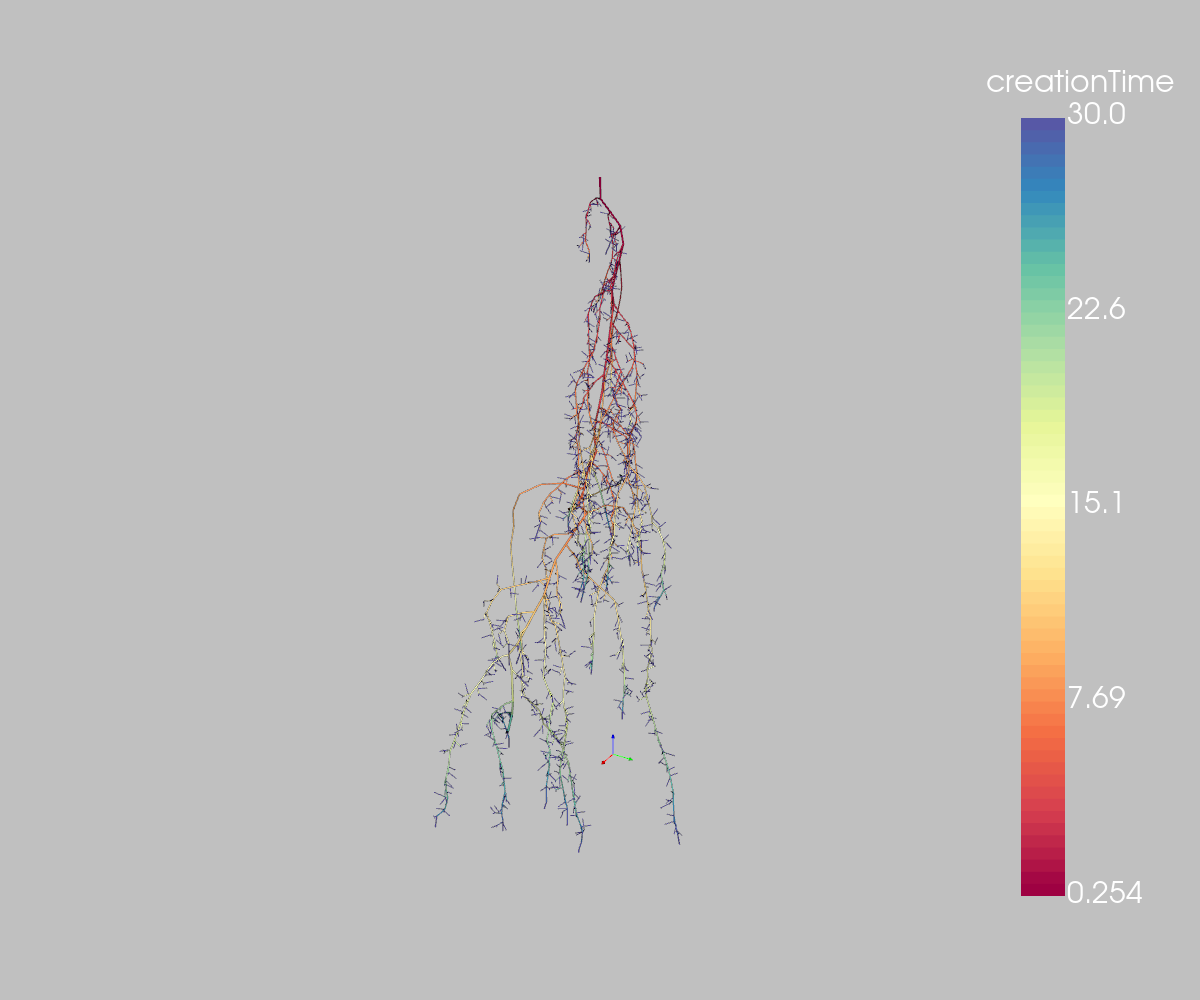

In [24]:
# Create instance describing a root system
rs = pb.RootSystem()

# Open plant and root parameter from a file
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010"
rs.readParameters(path + name + ".xml")

# Simulate
rs.initialize() 
rs.simulate(30) # [days]

# Export
rs.write("first_example.vtp") # for Paraview
rs.write("first_example.rsml") # e.g. gui/viewer/rsml_viewer.py

# Visualize
#print(rs, "creationTime",not isColab)
_ = vp.plot_roots(rs, "creationTime", interactiveImage = not isColab) # Plot, using vtk (e.g. "subType")

## 2. Post-processing (how to evaluate simulation results)

Basically, there are two methods 

1. Using class *RootSystem* directly, parameter values are given per root (root system is represented as polylines).

2. Using class *SegmentAnalyser*, which will consider all segments of the root system, parameter values are given per segment (root system is represented by nodes and segments).

### 2.1 Root system length vs time

A typical simulation loop will look like

In [7]:
rs = pb.RootSystem()
path = "../../../modelparameter/structural/rootsystem/"
name = "Zea_mays_1_Leitner_2010"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

""" Simulation loop """
simtime = 60.  # final simulation time [day]
dt = 1. # time step [day]
N = round(simtime / dt)  # number of iterations

for i in range(0, N):
    
    # Coupling to plant functional models or soil     
    
    rs.simulate(dt, False)
    
    # Coupling to plant functional models or soil 
    
    # Code for post-processing per time step (e.g. store relevant information in a list)
    

# Code for post-processing of the final result (write relevant results, e.g. csv, xls, etc.)
_  = vp.plot_roots(rs, "subType",interactiveImage = not isColab) # Plot, using vtk

Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


The following example will plot length versus time for the root system, and each subType (see *example2d_length.py*

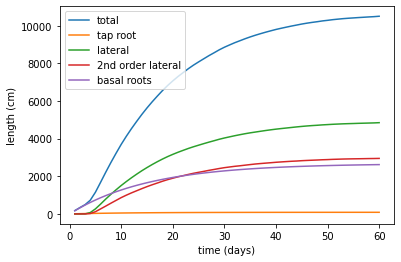

final tap root length:  85.85288555139974 cm


In [26]:
rs.initialize() # reset above simulation
scalar_type = "length" # "surface", "volume"
v_, v1_, v2_, v3_, v4_ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

""" Simulation loop """
for i in range(0, N):
    rs.simulate(dt)
    t = np.array(rs.getParameter("subType")) # value per root
    v = np.array(rs.getParameter(scalar_type)) # all random or specific parameters are accessible
    v_[i] = np.sum(v)
    v1_[i] = np.sum(v[t == 1])
    v2_[i] = np.sum(v[t == 2])
    v3_[i] = np.sum(v[t == 3])
    v4_[i] = np.sum(v[t == 4])
    
t_ = np.linspace(dt, N * dt, N)
plt.plot(t_, v_, t_, v1_, t_, v2_, t_, v3_, t_, v4_)
plt.xlabel("time (days)")
plt.ylabel(scalar_type + " (cm)")
plt.legend(["total", "tap root", "lateral", "2nd order lateral", "basal roots"])
# plt.savefig("myplot.png") # we could save it as png
plt.show()
print("final tap root length: ", v1_[-1], "cm")

## 2.2 Analyse results from the class *SegmentAnalyser* (values per segment) in a loop

The main functionality of the *SegmentAnalyser* class is:
* *getParameter(name)* as for *RootSystem* class, but returning a value for each segment, especially the "creationTime" of each segment
* *filter(name, min, max)* will keep only segments where the value of parameter *name* is within [min, max]
* *crop(sdf)* will keep only segments inside a geometry (e.g. in a soil core), segments intersecting the domain boundary are cut. 
* *distribution(...)* will create a 1d plot versus depth, where parameters are summed in layers 
* *distribution2d(...)* as above but 2d
* *mapPeriodic(length, width)* maps the unconstrained root system into a periodic domain
* *addData(name, data)* attach user data to the segments (e.g. simulation results for visualization or export)

Note that *SegmentAnalyser* is only loosly connected to the original simulation.

The first example shows how to obtain a depth distribution (values per segment) in a simulation loop.

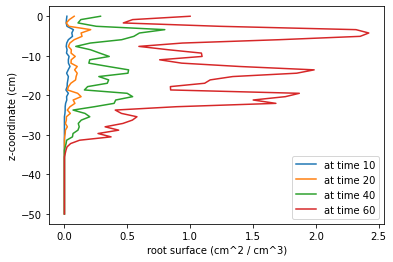

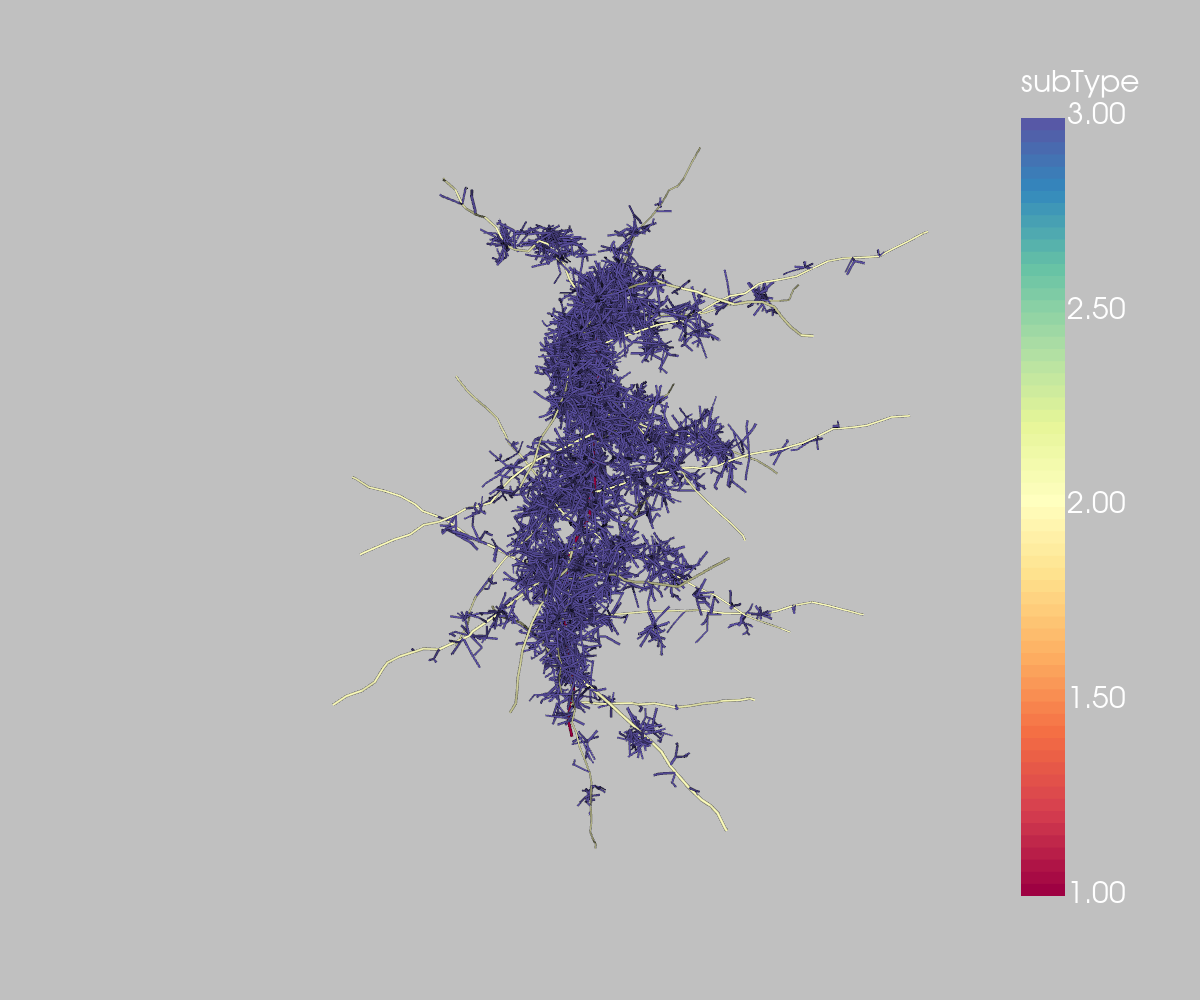

In [27]:
s = pb.RootSystem()
path = "../../../modelparameter/structural/rootsystem/"
name = "Lupinus_albus_Leitner_2014"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

simtimes = [0,10,20,40,60] # day
dt_ = np.diff(simtimes) # day
depth = 50 # cm
layers = 60 # [1]

""" Simulation loop """
rsd_ = []
for dt in dt_:    
    rs.simulate(dt)
    # _ = vp.plot_roots(rs, "subType") # to observe growth
    ana = pb.SegmentAnalyser(rs) # create a SegmentAnalyser object
    rsd = ana.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd) # store relevant data in a list

""" vizualize rld_ """
soilvolume = (depth / layers) * 10 * 10
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]

z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    plt.plot(rsd_[i,:], z_, label = "at time "+str(t))

plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend()
# plt.savefig("surface_density.png")
plt.show()
_ = vp.plot_roots(rs, "subType",interactiveImage = not isColab) # final result

## 3. Simulate a full plant

The definition of full plants is similar to that of root systems. Only, there are new parameters to take into account.

In [10]:
#create a plant from a parameter file
plant = pb.Plant()
path = "../../../modelparameter/structural/plant/"
name = "fspm2023"
plant.readParameters(path + name + ".xml")

In [11]:
# choose which organ parameters to overwrite
adaptSeed = False #change seed parameter
adaptRoot = False #change seed parameter
adaptLeaf = False #change leaf parameter
leafRadial = False #radial or not
adaptStem = False #change stem parameters
radialLeafShapeOptions = ["long","maple", "round", "flower"]
radialLeafShape = radialLeafShapeOptions[3]

Within the seed parameters are defined the number of tillers and basal roots. Roots and stems are (among others) defined according to their maximal lengths, growth rate and the distance between two children organs (roots, stems or leaves growing out of the organ in question).

In [57]:
if adaptSeed:
    srp = pb.SeedRandomParameter(plant)  # with default values
    srp.firstTil = 0  # [day] first emergence of a tiller
    srp.delayTil = 0  # [day] delay between the emergence of tillers
    srp.maxTil = 20 # [-] number of tillers 
    srp.firstB = 0  # [day] first emergence of a tiller
    srp.delayB = 0  # [day] delay between the emergence of tillers
    srp.maxB = 20 # [-] number of tillers 
    plant.setOrganRandomParameter(srp)
if adaptRoot:
    for p in plant.getOrganRandomParameter(pb.root):#we go through the root subtypes
        p.dxMin = 0.01 #resolution == minimum segment length
        p.dx = 0.1 #resolution == maximum segment length
        if p.subType == 1: #to which root subtype are the changes applied? Here: tap roots
            p.r = 10  # [cm/day] growth rate
            p.lmax = 20  # [cm] maximum length
            p.ln = 1 # [cm] interlateral distance
        plant.setOrganRandomParameter(p)
if adaptStem:
    for p in plant.getOrganRandomParameter(pb.stem):
        p.dxMin = 0.01 #resolution == minimum segment length
        p.dx = 0.1 #resolution == maximum segment length
        p.r = 10  # [cm/day] growth rate
        p.lmax = 20  # [cm] maximum length
        p.ln = 1 # [cm] interlateral distance
        plant.setOrganRandomParameter(p)

The leaf parameters can be adapted to represent different leaf 2D shapes. The 2D shapes can be defined according to the distance from the leaf center vain (non-radial geometry) or according to the distance from the leaf center (radial geometry).


In [47]:
if adaptLeaf:
    for p in plant.getOrganRandomParameter(pb.leaf):
        if leafRadial:
            if radialLeafShape=="long":
                p.lb =  1 # length of leaf stem
                p.la,  p.lmax = 3.5, 8.5
                p.areaMax = 10  # cm2, area reached when length = lmax
                N = 100  # resolution of the leaf shape
                phi = np.array([-90, -45, 0., 45, 90]) / 180. * np.pi
                l = np.array([3, 2.2, 1.7, 2, 3.5]) #distance from leaf center

            elif radialLeafShape == "maple":
                p.lb =  1 # length of leaf stem
                N = 100  # resolution of the leaf shape
                p.areaMax = 50 
                p.la,  p.lmax = 5, 11
                phi = np.array([-90, -45, 0., 45,67.5,70, 90]) / 180. * np.pi
                l = np.array([2, 2, 2, 4,1,1, 4]) #distance from leaf center

            elif radialLeafShape == "round":
                p.lb =  1 # length of leaf stem
                N = 100  # resolution of the leaf shape
                p.la,  p.lmax = 5, 11
                p.areaMax = 3.145*(((p.lmax-p.la - p.lb)/2)**2)
                phi = np.array([-90, -45, 0., 45,67.5,70, 90]) / 180. * np.pi
                l_ = (p.lmax - p.lb - p.la)/2
                l = np.array([l_ for x_i in range(len(phi))]) 

            elif radialLeafShape == "flower":
                N = 100  # resolution of the leaf shape
                p.areaMax = 100 
                p.la, p.lb, p.lmax = 5, 1, 11
                phi = np.array([-90., -67.5, -45, -22.5, 0, 22.5, 45, 67.5, 90]) / 180. * np.pi
                l = np.array([5., 1, 5, 1, 5, 1, 5, 1, 5])

            p.createLeafRadialGeometry(phi, l, N)   

        else:
            p.parametrisationType=1
            p.lb =  2 # length of leaf sheath
            p.la,  p.lmax = 3.5, 8.5
            p.areaMax = 10  # cm2, area reached when length = lmax
            N = 100  
            y = np.array([-3, -2.1, 0., 2.45, 3.5])
            l = np.array([0., 1.54, 1.7, 1.26, 0.])
            p.createLeafGeometry(y, l, N)         


        p.tropismT = 1 # 1: gravitropism
        #p.tropismN = 5
        #p.tropismS = 0.1
        plant.setOrganRandomParameter(p)

CPlantBox offers the option to print several vtk files to create a video of the growth in Paraview. When running the simulation on Colab, it is possible to print images at regular intervals.

Tiller stem type #4 was not defined, using main stem parameters instead, Seed::initialize: Plant 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead
2D leaf shape of a full grown leaf


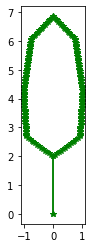

In [12]:
plant.initialize()
# Simulate
verbose = False
plant.simulate(30, verbose)
# Plot, using vtk
vp.plot_plant(plant, "organType",interactiveImage = not isColab)

# zoom on one leaf--theoreticall 2D shape once fully grown
print("2D leaf shape of a full grown leaf")
lorg = plant.getOrgans(pb.leaf)[0]
lrp = lorg.getLeafRandomParameter()  
if leafRadial:
    yy = np.linspace(0, lorg.leafLength(), N)
    geom_x, geom_y = [],[]
    for i, x in enumerate(lrp.leafGeometry):
        geom_x.extend(x)
        geom_y.extend([yy[i]] * len(x))
    geom_x = np.array(geom_x)
    geom_y = np.array(geom_y)        
    a  = lorg.leafArea() / lorg.leafLength() # scale radius
    plt.plot(geom_x * a, geom_y, "g*")
    plt.plot(-geom_x * a, geom_y, "g*")

else:
    geom_x_a =  np.array([0])
    geom_x_b = np.array([ x[-1] for x in lrp.leafGeometry]) #normalized x value along length
    geom_x = np.concatenate((geom_x_a,geom_x_b))
    geom_y_a = np.array([0])
    geom_y_b =np.linspace(lrp.lb, lorg.leafLength()+lrp.lb, len(geom_x_b))
    geom_y = np.concatenate((geom_y_a,geom_y_b))
    a  = lorg.leafArea() / lorg.leafLength() # scale radius
    plt.plot(geom_x * a, geom_y, "g-*")
    plt.plot(-geom_x * a, geom_y, "g-*")
plt.ylim([0, lrp.lmax+1])
plt.xlim([-a-1, a+1])
plt.axis('scaled')
plt.show()